In [101]:
### essential imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import json
import statsmodels.api as sm
from scipy.signal import find_peaks

In [102]:
### helper for position data ###
class invalid_trial(Exception):
    """
    raises an exception for an invalid trial number.
    """
    def __init__(self, message):
        super().__init__(message)

In [103]:
def position_data(trial: int, joint: str):
    """
    generates a data frame with the columns time, x, y, and z to
    represent the position of the joint, as time passes within the selected trial.
    """
    ### check if trial number is valid.
    if trial < 1:
        raise invalid_trial("please select a valid trial number")
    elif trial > 125:
        raise invalid_trial("please select a valid trial number")
    elif trial < 10:
        data_file = f'BB_FT_P0001_T000{trial}.json'
    elif trial < 100:
        data_file = f'BB_FT_P0001_T00{trial}.json'
    else:
        data_file = f'BB_FT_P0001_T0{trial}.json'
        
    
    total_data = f'../basketball/freethrow/data/P0001/{data_file}'
    with open(total_data, 'r') as file:
        data = json.load(file)
    
    x = []
    y = []
    z = []
    time = []
    for frame in range(240):
        position = data['tracking'][frame]['data']['player'][joint]
        x.append(position[0])
        y.append(position[1])
        z.append(position[2])
        time.append(data['tracking'][frame]['time'])

    data = pd.DataFrame({'x' : x, 'y' : y, 'z' : z, 'time' : time})
    return data

In [104]:
def total_joint_data(joint: str):
    """
    average position data from all trials, for the given joint. 
    """
    trial1 = position_data(1, joint)
    time = trial1['time']
    x = []
    y = []
    z = []
    for i in range (1, 126):
        trial_data = position_data(i, joint)
        trial_data.columns = [f'trial{i}_{col}' if col != 'time' else 'time' for col in trial_data.columns]
        x.append(trial_data[f'trial{i}_x'])
        y.append(trial_data[f'trial{i}_y'])
        z.append(trial_data[f'trial{i}_z'])

    x_df = pd.concat(x, axis=1)
    y_df = pd.concat(y, axis=1)
    z_df = pd.concat(z, axis=1)

    avg_x = x_df.mean(axis=1)
    avg_y = y_df.mean(axis=1)
    avg_z = z_df.mean(axis=1)

    averaged_data = pd.DataFrame({
        'time': time,
        'avg_x': avg_x,
        'avg_y': avg_y,
        'avg_z': avg_z
    })

    
    return averaged_data

In [105]:
def fit_joint(joint: str):
    """
    use lowess to fit the joint data.
    """
    data = total_joint_data(joint)
    time = data['time']
    x = data['avg_x']
    y = data['avg_y']
    z = data['avg_z']

    lowess_x = sm.nonparametric.lowess(x, time, frac=0.1)
    lowess_y = sm.nonparametric.lowess(y, time, frac=0.1)
    lowess_z = sm.nonparametric.lowess(z, time, frac=0.1)

    x_lowess = lowess_x[:, 1]
    y_lowess = lowess_y[:, 1]
    z_lowess = lowess_z[:, 1]

    lowess_results = pd.DataFrame({
        'time': time,
        'x_original': x,
        'y_original': y,
        'z_original': z,
        'x_lowess': x_lowess,
        'y_lowess': y_lowess,
        'z_lowess': z_lowess,
    })

    return lowess_results

In [106]:
def append_jerk(results):
    """add jerk to the results"""
    acceleration_x = np.gradient(np.gradient(results['x_lowess'], results['time']), results['time'])
    acceleration_y = np.gradient(np.gradient(results['y_lowess'], results['time']), results['time'])
    acceleration_z = np.gradient(np.gradient(results['z_lowess'], results['time']), results['time'])
    results['jerk_x'] = np.gradient(acceleration_x, results['time'])
    results['jerk_y'] = np.gradient(acceleration_y, results['time'])
    results['jerk_z'] = np.gradient(acceleration_z, results['time'])
    return results

In [107]:
def min_max_normalization(column):
    """
    normalizes a data column using min-max normalization.
    returns values in the range [-1, 1].
    """
    numerator = column - column.min()
    denominator = column.max() - column.min()
    return (2 * numerator/denominator) - 1

def normalize(results):
    """normalize results"""
    results['x_original'] = min_max_normalization(results['x_original'])
    results['y_original'] = min_max_normalization(results['y_original'])
    results['z_original'] = min_max_normalization(results['z_original'])
    results['x_lowess'] = min_max_normalization(results['x_lowess'])
    results['y_lowess'] = min_max_normalization(results['y_lowess'])
    results['z_lowess'] = min_max_normalization(results['z_lowess'])
    results['jerk_x'] = min_max_normalization(results['jerk_x'])
    results['jerk_z'] = min_max_normalization(results['jerk_z'])
    results['jerk_y'] = min_max_normalization(results['jerk_y'])
    return results

In [108]:
def find_main_extrema(results):
    """find significant extrema"""
    jerk_columns = ['jerk_x', 'jerk_y', 'jerk_z']
    x_main = []
    y_main = []
    z_main = []

    for jerk_column in jerk_columns:
        peaks, _ = find_peaks(results[jerk_column], prominence=0.1)
        valleys, _ = find_peaks(-results[jerk_column], prominence=0.1)
        extrema = sorted(np.concatenate((peaks, valleys)))
        results[f'{jerk_column}_abs'] = results[jerk_column].abs()

        main_extrema = []
        for extrema_index in extrema:
            current_time = results['time'].iloc[extrema_index]
            relevant_slice = results[(results['time'] >= current_time - 800) & 
                                     (results['time'] < current_time + 800)]
            
            max_val = relevant_slice[f'{jerk_column}_abs'].max()
            current_value = results[f'{jerk_column}_abs'].iloc[extrema_index]
            edge_case = relevant_slice[relevant_slice['time'] < current_time]
            has_edge_case = (edge_case[f'{jerk_column}_abs'].isin([1])).any()

            if (current_value == max_val and
                extrema_index not in main_extrema and not has_edge_case):
                main_extrema.append(extrema_index)
    
        if jerk_column == 'jerk_x':
            x_main.extend(main_extrema)
        if jerk_column == 'jerk_y':
            y_main.extend(main_extrema)
        if jerk_column == 'jerk_z':
            z_main.extend(main_extrema)

    return x_main, y_main, z_main

In [109]:
def segment(joint: str):
    """segment the times of joint movement"""
    results = fit_joint(joint)
    results = append_jerk(results)
    results = normalize(results)
    x, y, z = find_main_extrema(results)


    plt.figure(figsize=(14, 15))
    plt.subplot(3, 1, 1)
    plt.plot(results['time'], results['x_original'], label='Normalized X Original', color='blue', alpha=0.5)
    plt.plot(results['time'], results['x_lowess'], label='Normalized X LOWESS', color='orange')
    plt.plot(results['time'], results['jerk_x'], label='Normalized Jerk X', color='green')
    plt.scatter(results['time'].iloc[x], results['jerk_x'].iloc[x], color='red', label='Significant X Extrema', zorder=5)
    plt.title('X Values: Original, LOWESS, and Acceleration')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()

    # Plotting for Y
    plt.subplot(3, 1, 2)
    plt.plot(results['time'], results['y_original'], label='Normalized Y Original', color='blue', alpha=0.5)
    plt.plot(results['time'], results['y_lowess'], label='Normalized Y LOWESS', color='orange')
    plt.plot(results['time'], results['jerk_y'], label='Normalized Jerk Y', color='green')
    plt.scatter(results['time'].iloc[y], results['jerk_y'].iloc[y], color='red', label='Significant Y Extrema', zorder=5)

    plt.title('Y Values: Original, LOWESS, and Acceleration')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()

    # Plotting for Z
    plt.subplot(3, 1, 3)
    plt.plot(results['time'], results['z_original'], label='Normalized Z Original', color='blue', alpha=0.5)
    plt.plot(results['time'], results['z_lowess'], label='Normalized Z LOWESS', color='orange')
    plt.plot(results['time'], results['jerk_z'], label='Normalized Jerk Z', color='green')
    plt.scatter(results['time'].iloc[z], results['jerk_z'].iloc[z], color='red', label='Significant Z Extrema', zorder=5)

    plt.title('Z Values: Original, LOWESS, and Acceleration')
    plt.xlabel('Time')
    plt.ylabel('Normalized Values')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return results['time'].iloc[x].to_numpy(), results['time'].iloc[y].to_numpy(), results['time'].iloc[z].to_numpy()

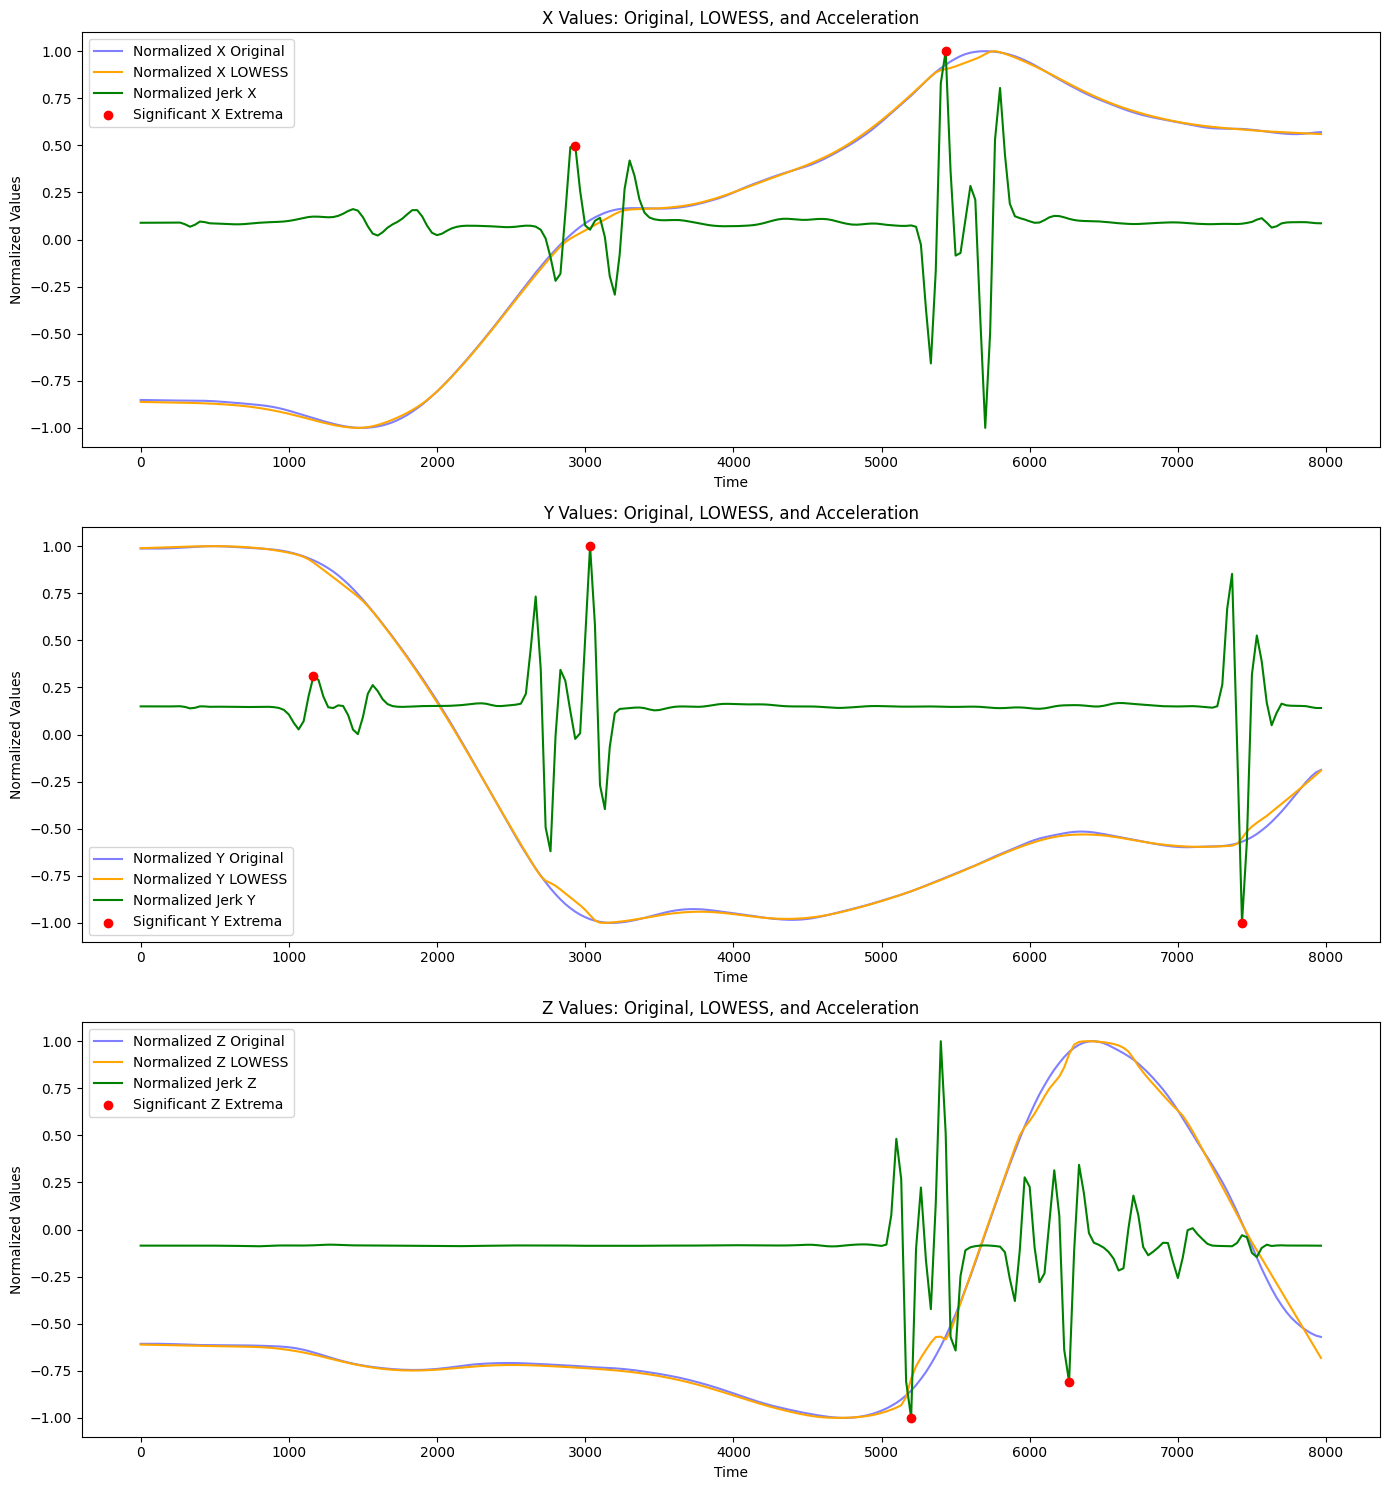

In [110]:
a = segment('R_ELBOW')

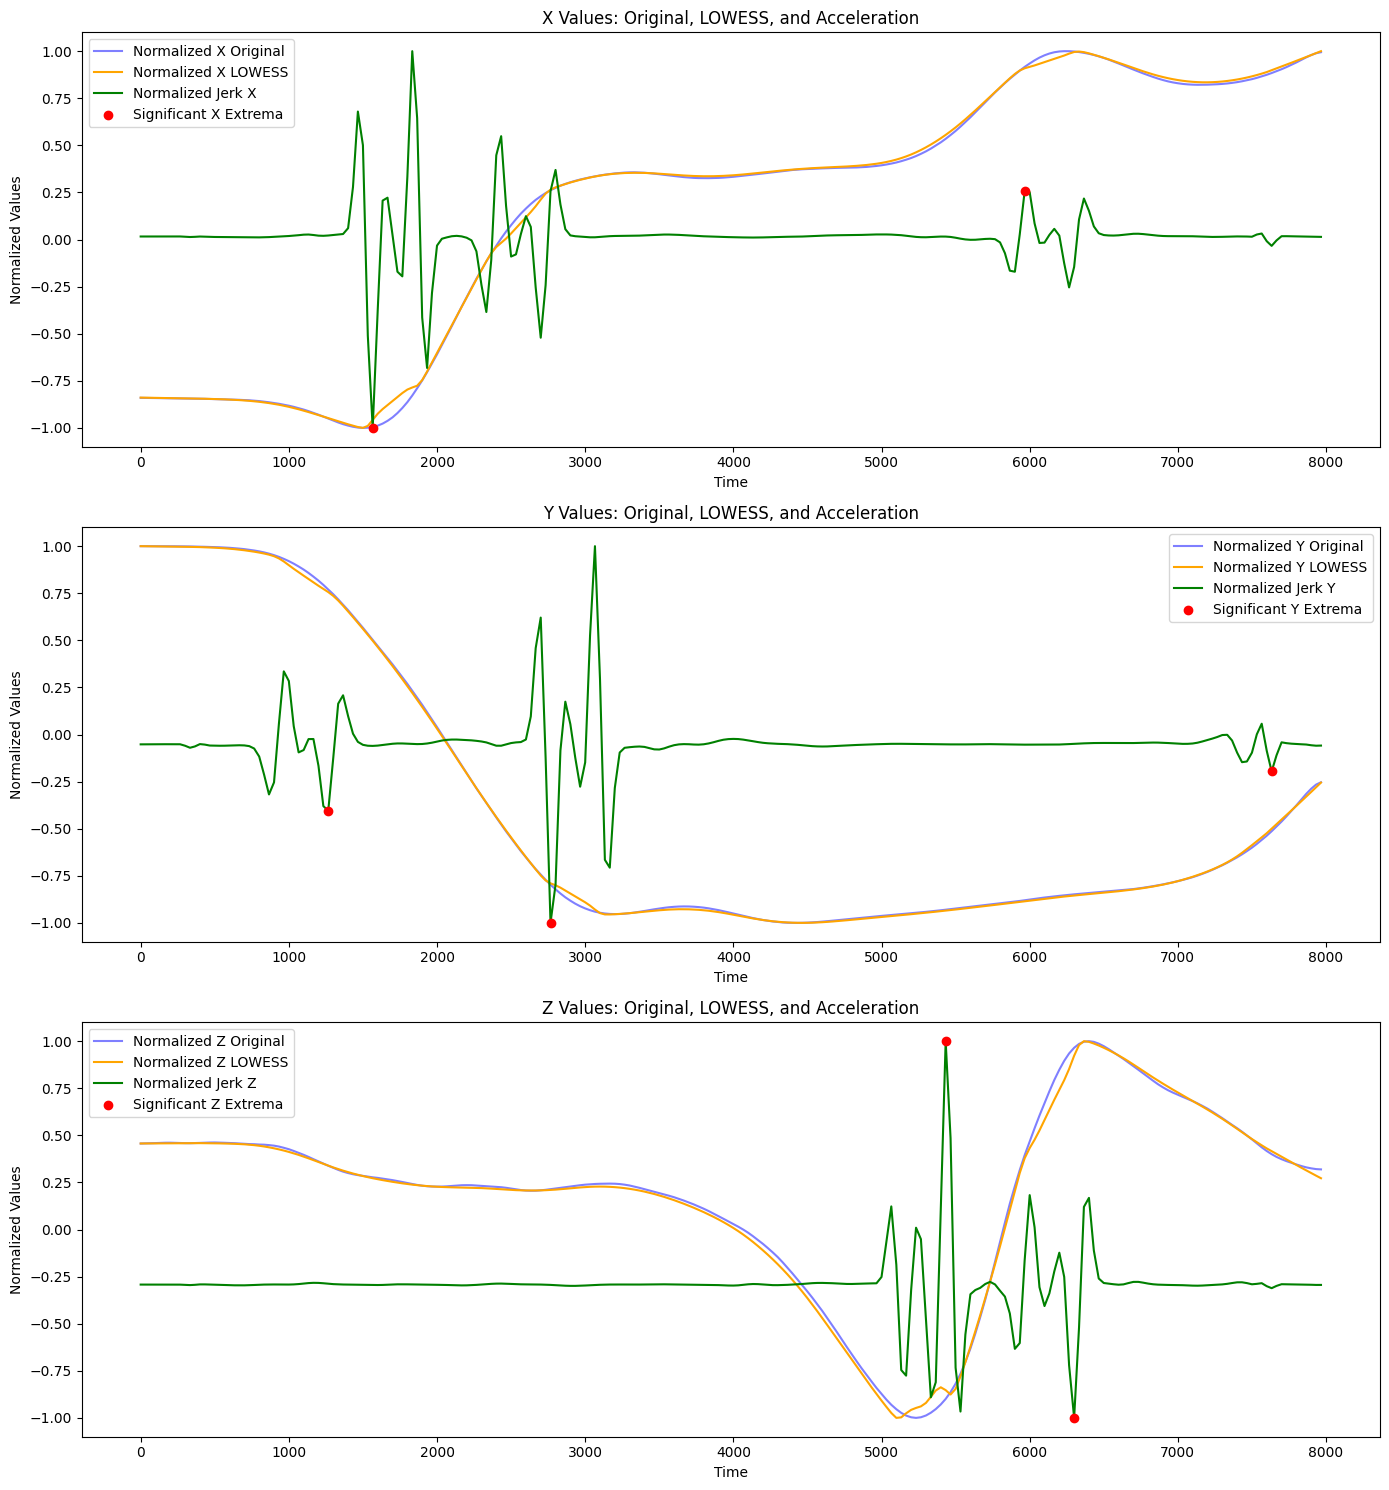

In [111]:
a = segment('R_HIP')